In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [4]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
print("Tensorflow version " + tf.__version__)

2024-07-18 18:17:32.240144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 18:17:32.240270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 18:17:32.362252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.0


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models, layers

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [7]:
IMAGE_SIZE = 512
EPOCHS = 10
CHANNELS = 3
BATCH_SIZE = 16 

In [8]:
tf.keras.backend.clear_session()
import gc
gc.collect()

0

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/leaf-diseases-extended/dataset/train",
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE
)

Found 96509 files belonging to 67 classes.


In [12]:
class_names= dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Cherry__powdery_mildew',
 'Coffee__healthy',
 'Coffee__rust',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Mango_Anthracnose',
 'Mango_Bacterial_Canker',
 'Mango_Cutting_Weevil',
 'Mango_Die_Back',
 'Mango_Gall_Midge',
 'Mango_Healthy',
 'Mango_Powdery_Mildew',
 'Mango_Sooty_Mould',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pe

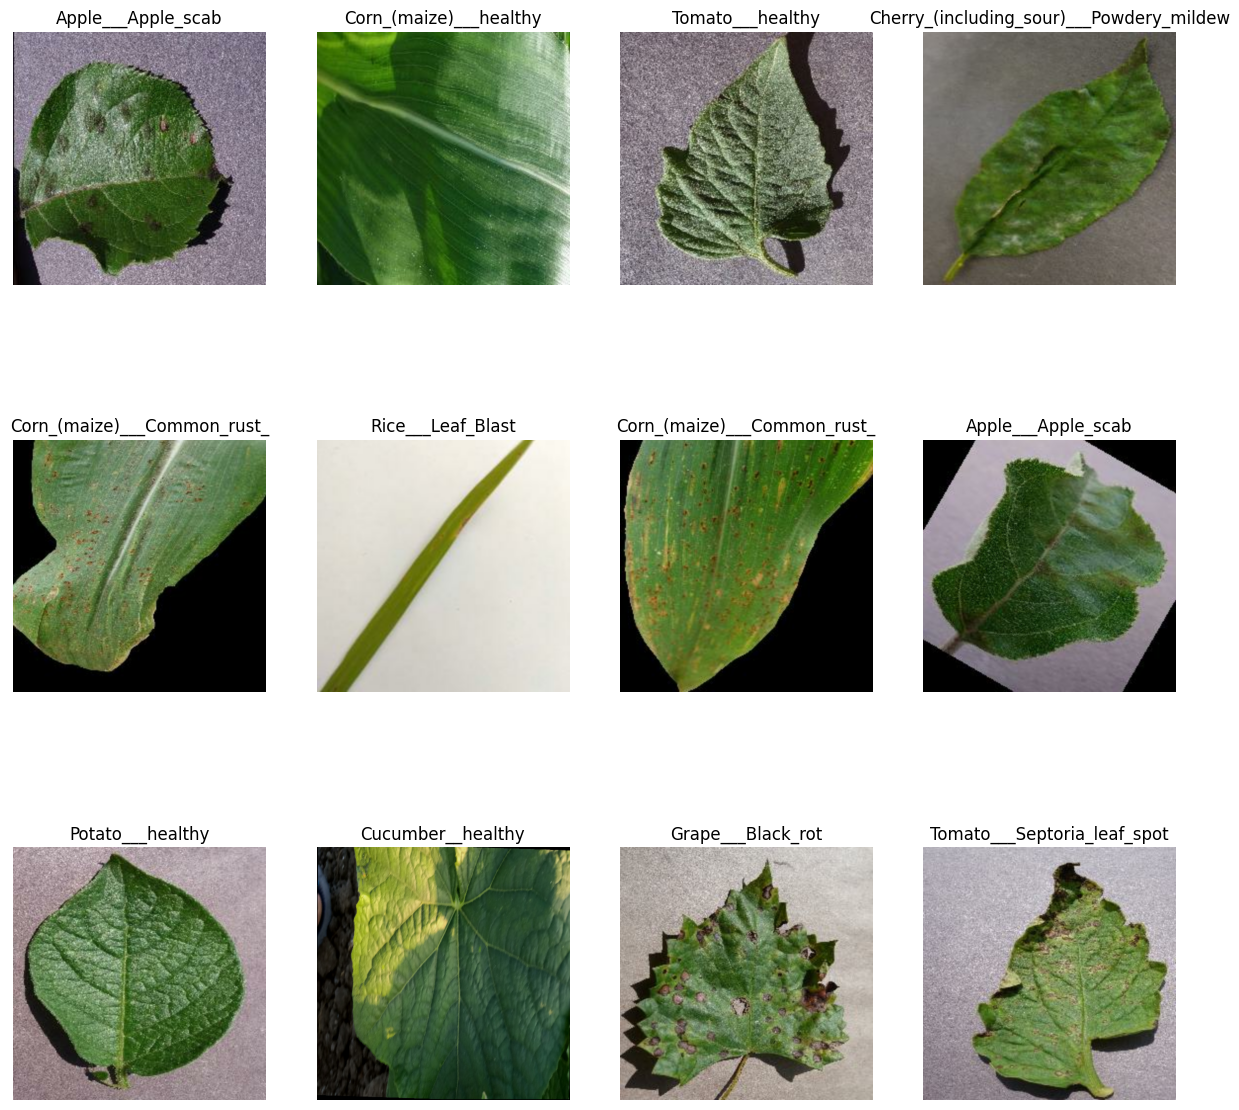

In [13]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=300):
    assert (train_split  + val_split) == 1
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)


    return train_ds, val_ds

# Partition the dataset
train_ds, val_ds = get_dataset_partitions_tf(dataset)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/leaf-diseases-extended/dataset/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 16573 files belonging to 67 classes.


In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [19]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets

# Initialize TensorFlow GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

AUTO = tf.data.experimental.AUTOTUNE

# Retry mechanism for accessing the dataset
retry_attempts = 5
for attempt in range(retry_attempts):
    try:
        GCS_DS_PATH = KaggleDatasets().get_gcs_path()
        break
    except Exception as e:
        print(f"Attempt {attempt + 1} of {retry_attempts} failed: {e}")
        if attempt + 1 < retry_attempts:
            print("Waiting and retrying...")
        else:
            raise

print("Dataset path:", GCS_DS_PATH)


Physical devices cannot be modified after being initialized
Attempt 1 of 5 failed: Unexpected response from the service. Response: {'errors': ["We're still copying your files, please check again later."], 'error': {'code': 4, 'details': []}, 'wasSuccessful': False}.
Waiting and retrying...
Dataset path: gs://kds-cc88c8328fd431520e1782f93722153bac8288f2020933d6e7ca3f1d


In [20]:

num_classes = len(class_names)
if num_classes < 1:
    raise ValueError("The class names list is empty. Please define your class names correctly.")


In [21]:
import math
import re
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, DenseNet201

print("Tensorflow version " + tf.__version__)  # Ensure this is 2.x

# Load the DenseNet201 model without the top classification layer
rnet = DenseNet201(
    input_shape=(512, 512, 3),
    weights='imagenet',
    include_top=False
)

# Create the model and add new layers
model = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


Tensorflow version 2.15.0
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
import tensorflow as tf
print(tf.__version__)  # Ensure this is 2.x


2.15.0


In [22]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [23]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [24]:
NUM_TRAINING_IMAGES = len(train_ds)
NUM_VALIDATION_IMAGES = len(val_ds)
STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE

print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 5428 training images, 603 validation images


In [25]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history = model.fit(
    train_ds, 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10


2024-07-18 18:48:52.328644: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_131086__.89107] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-18 18:48:57.912882: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m5.584419523s

********************************
[Compiling module a_inference_one_step_on_data_131086__.89107] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
I0000 00:00:1721328537.914637     142 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721328538.208004     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


376/376 ━━━━━━━━━━━━━━━━━━━━ 606s 601ms/step - loss: 3.6892 - sparse_categorical_accuracy: 0.1924 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 226s 602ms/step - loss: 1.4916 - sparse_categorical_accuracy: 0.7325 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 226s 601ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.8738 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 226s 601ms/step - loss: 0.3851 - sparse_categorical_accuracy: 0.9070 - learning_rate: 3.4000e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.
Epoch 5/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 226s 600ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9228 - learning_rate: 4.2000e-05

E

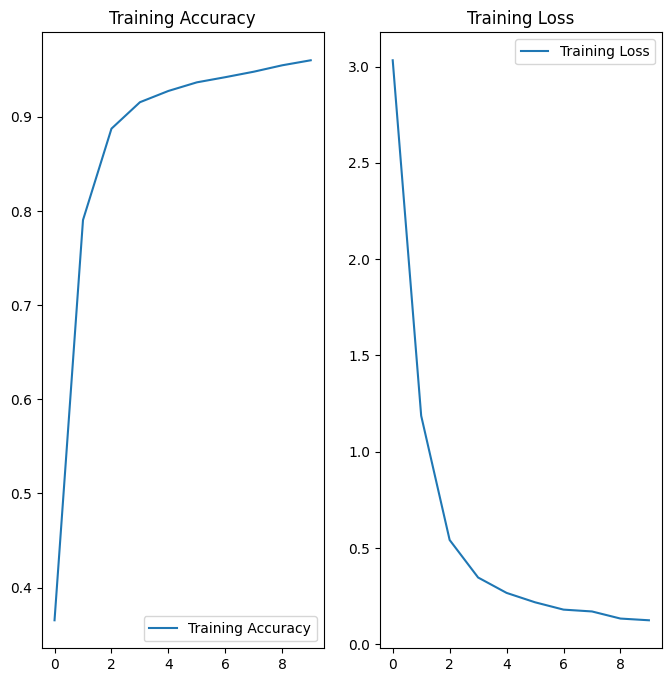

In [26]:
acc = history .history['sparse_categorical_accuracy']
loss = history.history['loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [27]:
scores = model.evaluate(test_ds)

   1/1036 ━━━━━━━━━━━━━━━━━━━━ 5:17:48 18s/step - loss: 0.0316 - sparse_categorical_accuracy: 1.0000

W0000 00:00:1721330877.516865     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   9/1036 ━━━━━━━━━━━━━━━━━━━━ 2:43 160ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9673

Invalid SOS parameters for sequential JPEG


 133/1036 ━━━━━━━━━━━━━━━━━━━━ 2:23 159ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG


 480/1036 ━━━━━━━━━━━━━━━━━━━━ 1:28 159ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG


 769/1036 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG


 776/1036 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - loss: 0.0715 - sparse_categorical_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG


 943/1036 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 213s 188ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9775


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


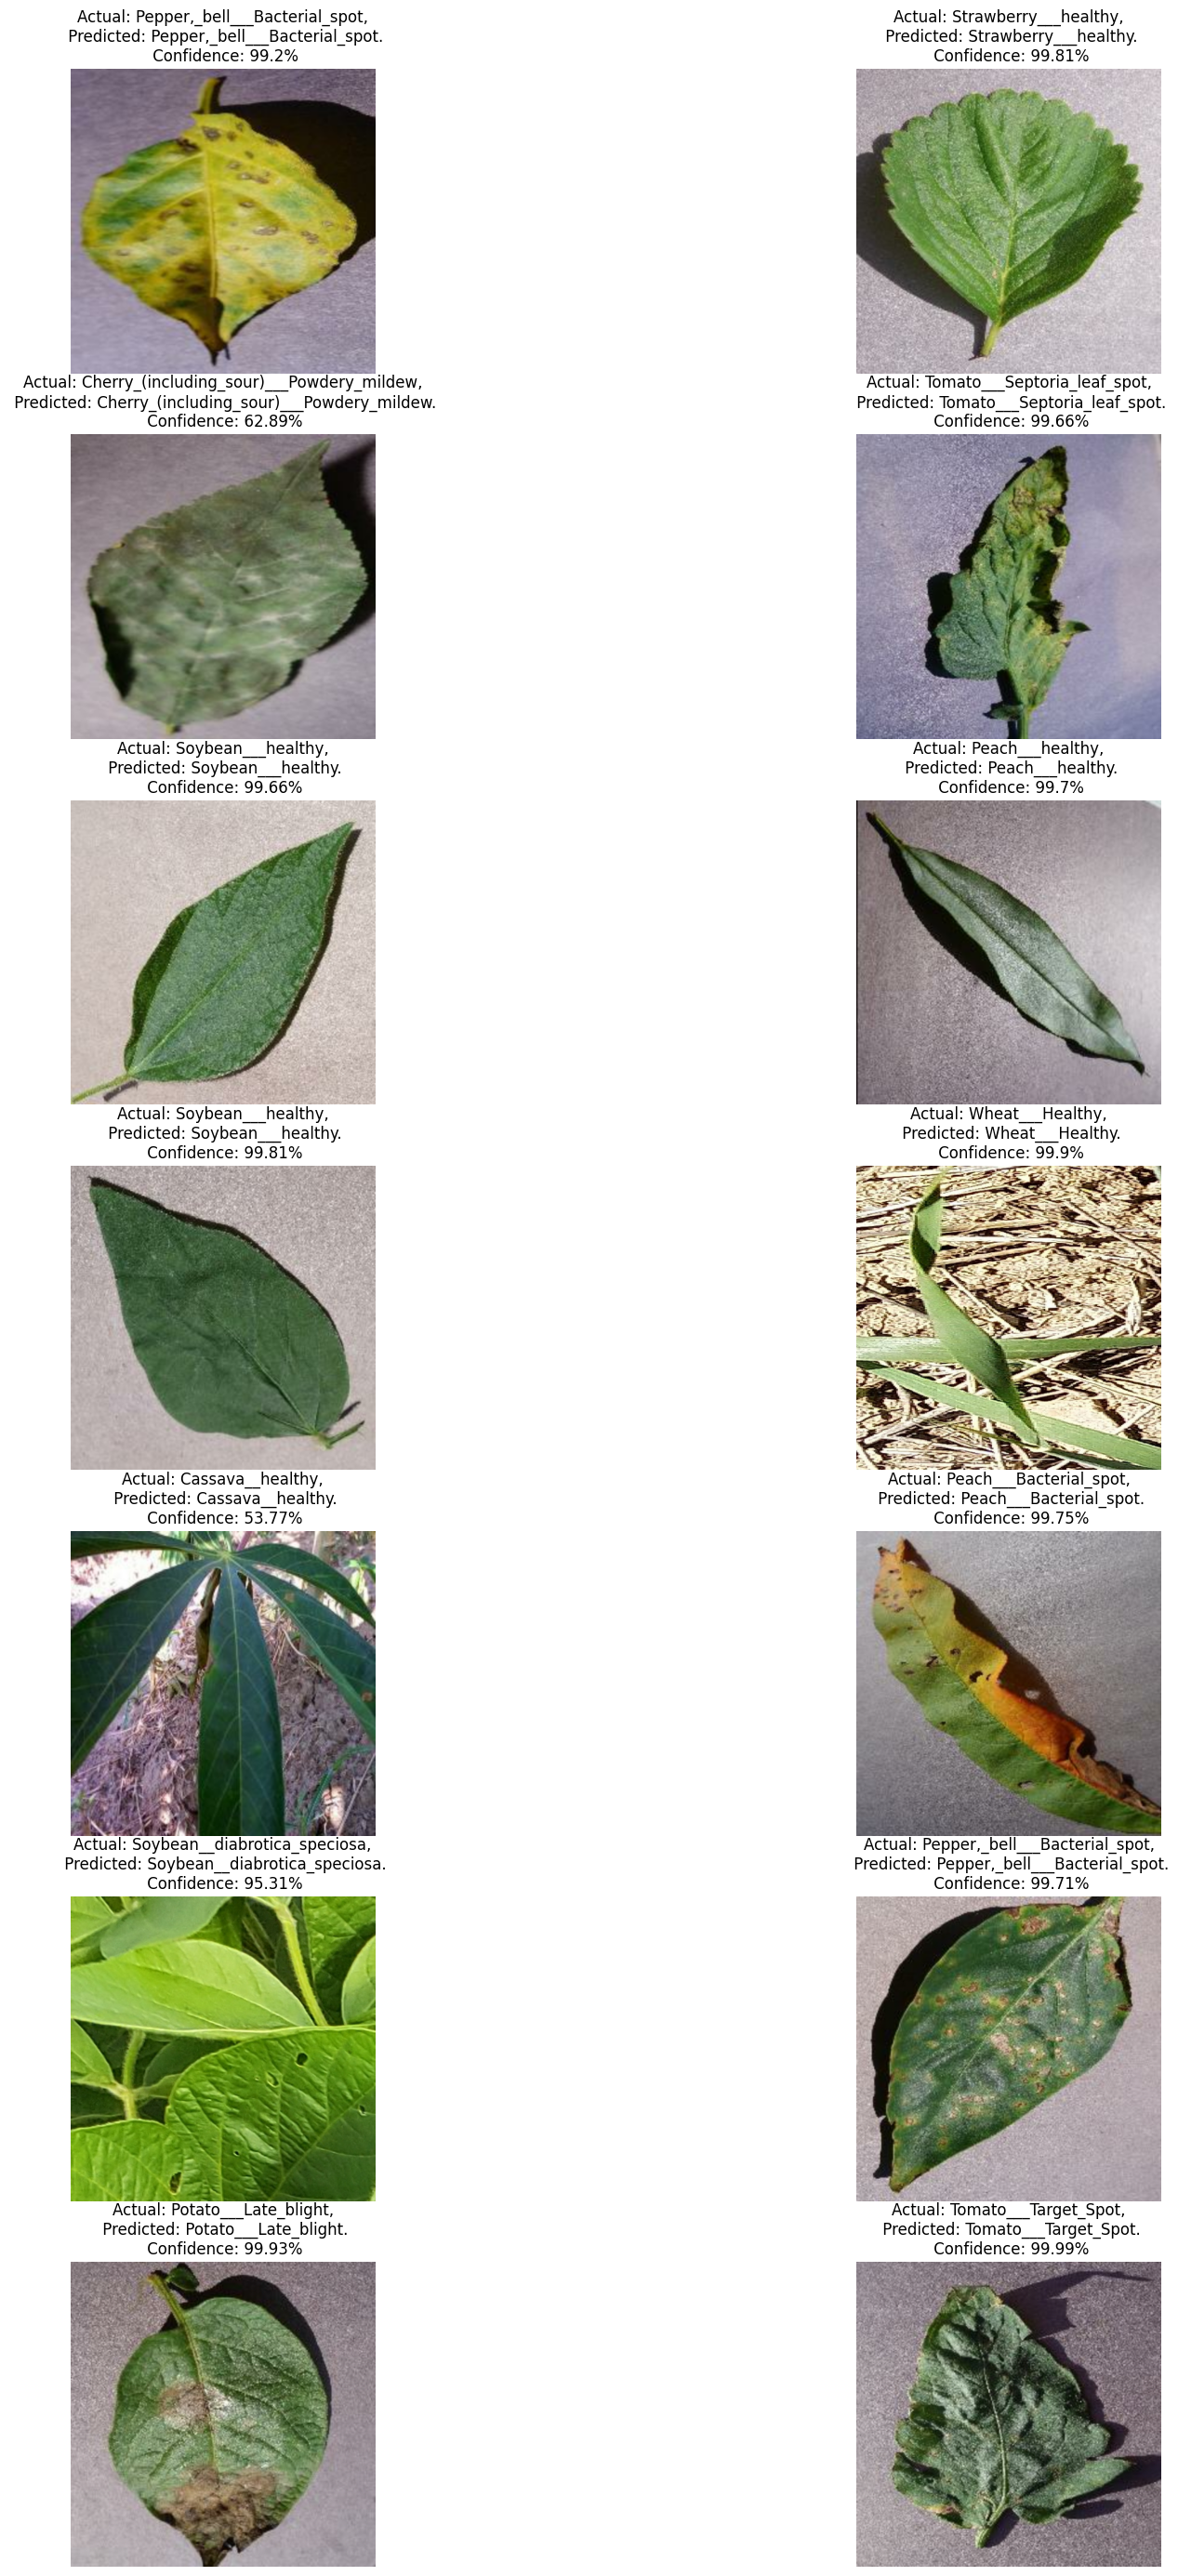

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(20, 40))
for images, labels in test_ds.take(1):
    for i in range(14):
        ax = plt.subplot(8, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")